In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 3.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-dpzchtbj
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-dpzchtbj
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=95d6c2d226bbb80eb00e74f4d99c674203e361f42fa768830cf695fc3e6081ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1gd7y7x/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
dynamics_utility = import_local_or_github('dynamics_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_a} = \mathbf{{h_a}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_b} = \mathbf{{h_b}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[pink]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} / \bbox[lightblue]{m} + \bbox[pink]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

In [4]:
f = planar_drone.F().f
h_a = planar_drone.H('h_gps').h
h_b = planar_drone.H('h_camera_theta_k').h
h_c = planar_drone.H('h_camera_imu').h

### Linearize the dynamics and measurement function

We need linearized dynamics of the form:

$
\mathbf{x_{k+1}} = A\mathbf{x_k} + B\mathbf{u_k}
$

$
\mathbf{y_k} = C\mathbf{x_k} + D\mathbf{u_k}
$

We will do that numerically using the same functions as before.

In [5]:
jacobian_numerical = dynamics_utility.jacobian_numerical
rk4_discretize = dynamics_utility.rk4_discretize

In [6]:
# initial condition for planar drone in hover mode

# x = [theta, thetadot, x, xdot, z, zdot, k]
x0 = np.array([0, 0, 0, 0, 1, 0, 1])
u0 = np.array([0, 0])

In [7]:
def f_discrete(x, u):
    dt = 0.1
    return rk4_discretize(f, x, u, dt)

In [8]:
A, B = jacobian_numerical(f_discrete, x0, u0)

In [9]:
C_a, D_a = jacobian_numerical(h_a, x0, u0)
C_b, D_b = jacobian_numerical(h_b, x0, u0)
C_c, D_c = jacobian_numerical(h_c, x0, u0)

# Exercises

1. Determine the rank of the observability matrix for each measurement option. Which ones are observable?
2. Determine the observability Gramian for each measurement option:
  * Analyze the eigenvalues/eigenvectors to determine the most observable state combinations
  * Analyze the matrix inverse of the Gramian to determien the most observable individual states

3. Do your results agree with your Kalman filter from the prior lesson?  

In [10]:
O_a = np.vstack([C_a, C_a@A, C_a@A@A])
print(A.shape[0])
print(np.linalg.matrix_rank(O_a))

7
7


In [15]:
O_b = np.vstack([C_b, C_b@A, C_b@A@A])
print(A.shape[0])
print(np.linalg.matrix_rank(O_b))

7
4


In [13]:
O_c = np.vstack([C_c, C_c@A, C_c@A@A, C_c@A@A@A])
print(A.shape[0])
print(np.linalg.matrix_rank(O_c))

7
4


# Observability Gramian

In [16]:
W_a = O_a.T@O_a
W_b = O_b.T@O_b
W_c = O_c.T@O_c

In [17]:
W_a

array([[3.  , 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.3 , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 3.  , 0.3 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.3 , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 3.  , 0.3 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.3 , 0.05, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 3.  ]])

In [20]:
def show_eigs_for_W(W):
  eigvals, eigvecs = np.linalg.eig(W)

  # sort eigenvalues from largest to smallest
  ixsort = np.argsort(eigvals)[::-1]

  print(np.round(eigvals[ixsort], 2))

  print(np.round(eigvecs[:,ixsort], 2))

In [21]:
show_eigs_for_W(W_a)

[3.03 3.03 3.03 3.   0.02 0.02 0.02]
[[ 0.    0.99  0.    0.    0.   -0.1   0.  ]
 [ 0.    0.1   0.    0.    0.    0.99  0.  ]
 [ 0.99  0.    0.    0.   -0.1   0.    0.  ]
 [ 0.1   0.    0.    0.    0.99  0.    0.  ]
 [ 0.    0.    0.99  0.    0.    0.   -0.1 ]
 [ 0.    0.    0.1   0.    0.    0.    0.99]
 [ 0.    0.    0.    1.    0.    0.    0.  ]]


In [22]:
def plot_Finv_for_W(W, lam=1e-6):
  Finv = np.linalg.inv(W + lam*np.eye(len(W)))
  img = plt.imshow(np.log(Finv), origin='upper')

  cbar = plt.colorbar(img)
  cbar.set_label('log(min err var)', rotation=270, labelpad=15)

/tmp/ipython-input-1375640756.py:3: RuntimeWarning: divide by zero encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')
/tmp/ipython-input-1375640756.py:3: RuntimeWarning: invalid value encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')


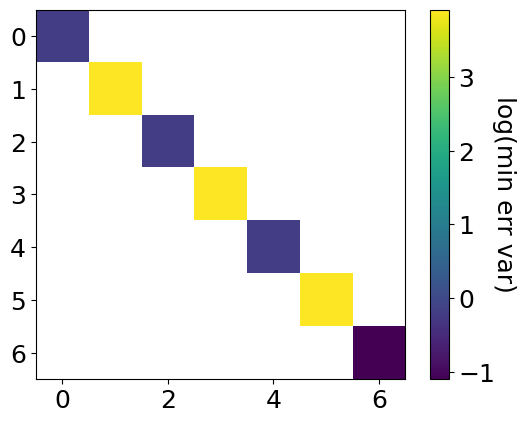

In [26]:
plot_Finv_for_W(W_a)

/tmp/ipython-input-1375640756.py:3: RuntimeWarning: divide by zero encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')
/tmp/ipython-input-1375640756.py:3: RuntimeWarning: invalid value encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')


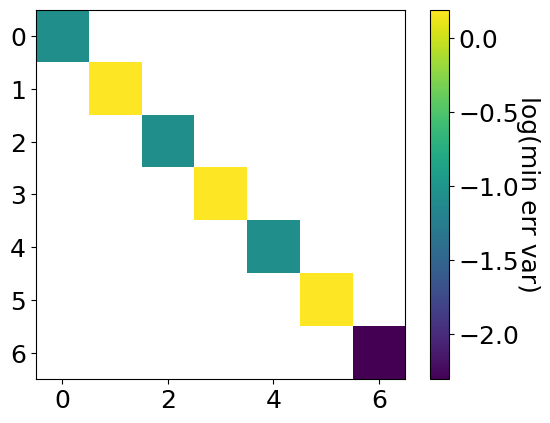

In [27]:
matrix_power = np.linalg.matrix_power

O_a = np.vstack([C_a@matrix_power(A, n) for n in range(10)])
W_a_n = O_a.T@O_a
plot_Finv_for_W(W_a_n)